In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
import pandas as pd
import numpy as pd

from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
img_size=336
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.0,
    width_shift_range=0.2,
    height_shift_range=0.2)

valid_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/sugarcane_aug/train',  #training data path
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        '/content/drive/MyDrive/sugarcane_aug/val', #validation data path
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)

SIZE=336
channel=3


def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE,channel))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(5,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    #lr=0.002
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    #optimizer = SGD(lr=1e-5,momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

filepath = '/content/drive/MyDrive/sugarcane_dense121.h5'   #path where the model should be saved
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

model = build_densenet()

Found 1200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 336, 336, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 336, 336, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)    

In [ ]:
history = model.fit(train_generator,
                   validation_steps = valid_generator.n // valid_generator.batch_size,
                   validation_data = valid_generator,
                   steps_per_epoch = train_generator.n // train_generator.batch_size ,
                   epochs = 50,
                   callbacks = [annealer,checkpoint])


Epoch 1/50
37/37 [==============================] - 794s 20s/step - loss: 2.8165 - accuracy: 0.2098 - val_loss: 1.6899 - val_accuracy: 0.2604

Epoch 00001: val_loss improved from inf to 1.68991, saving model to /content/drive/MyDrive/sugarcane_dense121.h5
Epoch 2/50
37/37 [==============================] - 103s 3s/step - loss: 2.5185 - accuracy: 0.2517 - val_loss: 1.5154 - val_accuracy: 0.3594

Epoch 00002: val_loss improved from 1.68991 to 1.51543, saving model to /content/drive/MyDrive/sugarcane_dense121.h5
Epoch 3/50
37/37 [==============================] - 103s 3s/step - loss: 2.1659 - accuracy: 0.3366 - val_loss: 1.3115 - val_accuracy: 0.4531

Epoch 00003: val_loss improved from 1.51543 to 1.31150, saving model to /content/drive/MyDrive/sugarcane_dense121.h5
Epoch 4/50
37/37 [==============================] - 101s 3s/step - loss: 1.8453 - accuracy: 0.3863 - val_loss: 1.0328 - val_accuracy: 0.6458

Epoch 00004: val_loss improved from 1.31150 to 1.03284, saving model to /content/dri

In [ ]:

model.save(filepath)

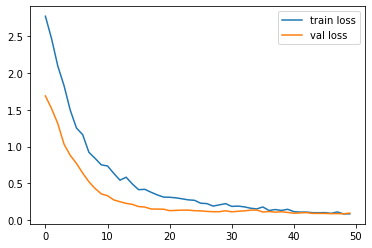

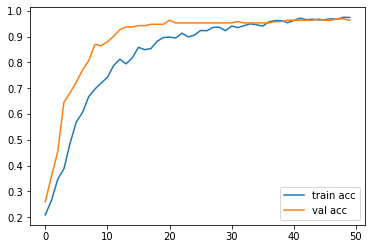

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/sugarcane_dense_loss_curve')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/sugarcane_dense_acc_curve')


In [ ]:
from tensorflow import keras
model = keras.models.load_model(filepath)

In [ ]:
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
img_size=336
test_datagen = ImageDataGenerator(
   
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/sugarcane_aug/test',
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 100 images belonging to 5 classes.


In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
target_names = []

for key in train_generator.class_indices:

    target_names.append(key)

In [ ]:
predict = model.predict_generator(valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
predict1=model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[39  0  1  0  0]
 [ 1 38  0  1  0]
 [ 2  2 36  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 40]]
Confusion matrix, without normalization


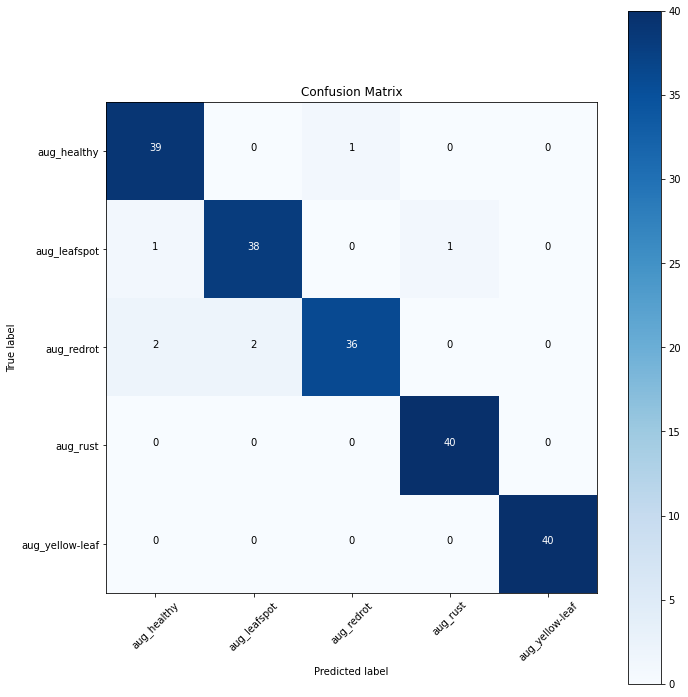

In [ ]:
y_pred = np.argmax(predict, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(valid_generator.classes, y_pred)
print(cm)

import itertools
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')




Confusion Matrix
[[20  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [ 1  0  0  0 19]]
Confusion matrix, without normalization


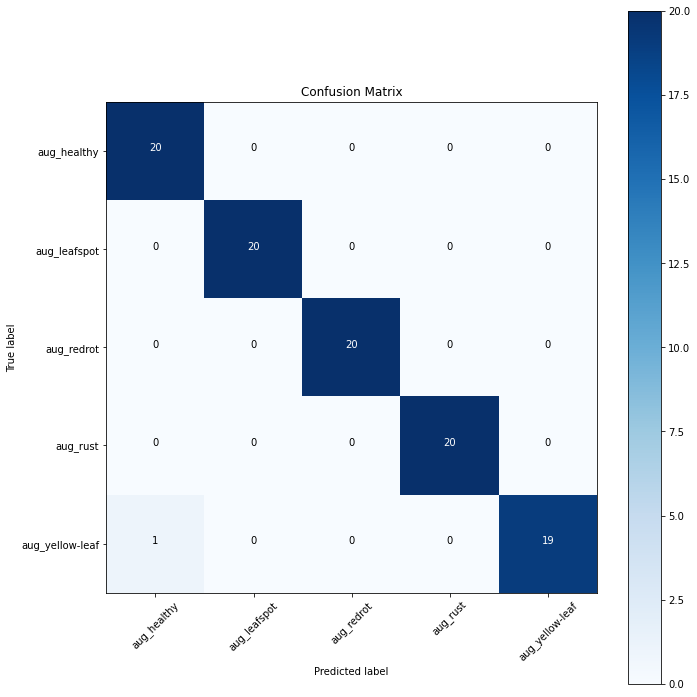

In [ ]:
y_pred1 = np.argmax(predict1, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_generator.classes, y_pred1)
print(cm)

import itertools
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')




In [ ]:
print(classification_report(test_generator.classes, y_pred1, target_names=target_names))

                 precision    recall  f1-score   support

    aug_healthy       0.95      1.00      0.98        20
   aug_leafspot       1.00      1.00      1.00        20
     aug_redrot       1.00      1.00      1.00        20
       aug_rust       1.00      1.00      1.00        20
aug_yellow-leaf       1.00      0.95      0.97        20

       accuracy                           0.99       100
      macro avg       0.99      0.99      0.99       100
   weighted avg       0.99      0.99      0.99       100



In [ ]:
from tensorflow import keras
classifier = keras.models.load_model("/content/drive/MyDrive/sugarcane_dense121.h5")

In [ ]:
class_dict = train_generator.class_indices
print(class_dict)
li = list(class_dict.keys())
print(li)

{'aug_healthy': 0, 'aug_leafspot': 1, 'aug_redrot': 2, 'aug_rust': 3, 'aug_yellow-leaf': 4}
['aug_healthy', 'aug_leafspot', 'aug_redrot', 'aug_rust', 'aug_yellow-leaf']


Following is our prediction:


TypeError: ignored

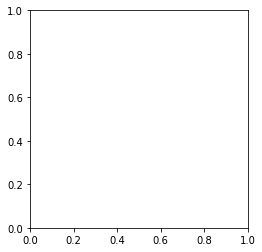

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
image_path = "/content/drive/MyDrive/sugarcane_aug/test/aug_rust/rust5.jpg"
new_img = image.load_img(image_path, target_size=(336, 336))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

     
        
##Another way
#img_class = classifier.predict_classes(img)
#img_prob = classifier.predict_proba(img)
#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(img)
plt.axis('off')
plt.title(class_name)
plt.show()

## **TFlite Conversion**

In [ ]:
from tensorflow import keras
filepath ="/content/drive/MyDrive/sugarcane_dense121.h5"
model = keras.models.load_model(filepath)

In [3]:
!pip install tflite

     |████████████████████████████████| 92kB 7.9MB/s 


In [4]:
import tensorflow as tf
import tflite
print(tf.__version__)
print(tflite.__version__)

2.4.1
2.4.0


In [ ]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_sugarcane_densemodel.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmkl1t9o4/assets


28961636

## **TFLite Prediction**

In [5]:
ti=tf.lite.Interpreter(model_path="/content/drive/MyDrive/sugarcane_aug/tf_lite_sugarcane_densemodel.tflite")

In [6]:
ti.allocate_tensors()

In [133]:
from PIL import Image
img=Image.open("/content/drive/MyDrive/sugarcane_aug/internet test/aug_yellow-leaf/yellow_9.JPG")

In [134]:
img.load()

In [135]:
import PIL
img=img.resize((336,336),PIL.Image.ANTIALIAS)
import numpy as np
img=np.asarray(img,dtype="int32")/255.0
img=np.expand_dims(img,0).astype(np.float32)

input_details=ti.get_input_details()

In [136]:
ti.set_tensor(input_details[0]['index'],img)
ti.invoke()

In [137]:
output_details=ti.get_output_details()
ti.get_tensor(output_details[0]['index'])


array([[0.2660289 , 0.01940922, 0.01218778, 0.00073844, 0.70163566]],
      dtype=float32)

In [138]:
op=ti.get_tensor(output_details[0]['index'])
print(np.argmax(op))

4


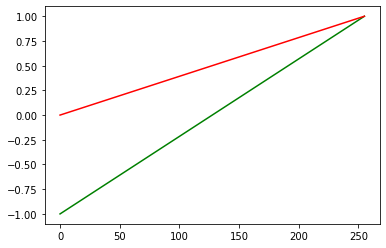

In [ ]:
from matplotlib import pyplot as plt
x=[]
x1=[]
for i in range(256):
  x.append((i-127.5)/127.5)
  x1.append(i/255.0)
plt.plot(x,'g')
plt.plot(x1,'r')
plt.show()
